In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from datetime import time
import matplotlib.dates as mdates
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
%matplotlib notebook

In [2]:
filePath = 'data/july-2017-thru-june-2018.txt'

In [3]:
accre_data = pd.read_csv(filePath, delimiter='|')
accre_data.head(100)

/Users/gcdunn/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,JobID,JobIDRaw,Cluster,Partition,Account,Group,GID,User,UID,Submit,Eligible,Start,End,Elapsed,ExitCode,State,NNodes,NCPUS,ReqCPUS,ReqMem,ReqGRES,ReqTRES,Timelimit,NodeList,JobName
0,15806649,15806649,accre,production,h_vuiis,h_vuiis,36052,masispider,NaN,2017-07-02T00:40:58,2017-07-02T00:42:59,2017-07-03T02:13:59,2017-07-04T03:19:20,1-01:05:21,0:0,COMPLETED,1,2,2,12Gn,NaN,"cpu=2,mem=12G,node=1",9-04:00:00,vmp1085,WOODWARD_TCP-x-228324-x-228324-x-301-x-Multi_A...
1,15806664,15806664,accre,production,h_vuiis,h_vuiis,36052,masispider,NaN,2017-07-02T00:40:58,2017-07-02T00:42:59,2017-07-03T02:20:08,2017-07-04T02:11:55,23:51:47,0:0,COMPLETED,1,2,2,12Gn,NaN,"cpu=2,mem=12G,node=1",9-04:00:00,vmp1099,WOODWARD_TCP-x-115174-x-115174-x-301-x-Multi_A...
2,15806670,15806670,accre,production,h_vuiis,h_vuiis,36052,masispider,NaN,2017-07-02T00:40:58,2017-07-02T00:42:59,2017-07-03T02:41:13,2017-07-04T04:41:04,1-01:59:51,0:0,COMPLETED,1,2,2,12Gn,NaN,"cpu=2,mem=12G,node=1",9-04:00:00,vmp1126,WOODWARD_TCP-x-215607-x-215607-x-301-x-Multi_A...
3,15806671,15806671,accre,production,h_vuiis,h_vuiis,36052,masispider,NaN,2017-07-02T00:40:58,2017-07-02T00:42:59,2017-07-03T02:51:53,2017-07-04T10:54:13,1-08:02:20,0:0,COMPLETED,1,2,2,12Gn,NaN,"cpu=2,mem=12G,node=1",9-04:00:00,vmp230,WOODWARD_TCP-x-116214-x-116214-x-1701-x-Multi_...
4,15811617,15811617,accre,production,cms_samtest,cms_samtest,59297,uscms010,NaN,2017-07-01T05:00:00,2017-07-01T05:00:00,2017-07-01T05:00:01,2017-07-01T05:00:11,00:00:10,0:0,COMPLETED,1,1,1,4000Mn,NaN,"cpu=1,mem=4000M,node=1",2-00:00:00,vmp1242,bl_aa7c22e04f21
5,15811618,15811618,accre,production,cms_stage2,cms_stage1,59298,autocms,9209.0,2017-07-01T05:00:01,2017-07-01T05:00:01,2017-07-01T05:00:04,2017-07-01T05:03:22,00:03:18,0:0,COMPLETED,1,1,1,2Gc,NaN,"cpu=1,mem=2G,node=1",12:00:00,vmp1063,skim_test
6,15811619,15811619,accre,production,cms_stage2,cms,31000,tuos,126986.0,2017-07-01T05:00:02,2017-07-01T05:00:02,2017-07-01T05:00:04,2017-07-01T05:02:07,00:02:03,0:0,COMPLETED,1,1,1,2Gc,NaN,"cpu=1,mem=2G,node=1",12:00:00,vmp1062,skim_test
7,15811621,15811621,accre,production,cms_samtest,cms_samtest,59297,uscms010,NaN,2017-07-01T05:00:22,2017-07-01T05:00:22,2017-07-01T05:00:23,2017-07-01T05:00:33,00:00:10,0:0,COMPLETED,1,1,1,4000Mn,NaN,"cpu=1,mem=4000M,node=1",2-00:00:00,vmp1242,bl_33ee450ebdc4
8,15811624,15811624,accre,production,cms_stage2,cms_stage1,59298,autocms,9209.0,2017-07-01T05:01:01,2017-07-01T05:01:01,2017-07-01T05:01:02,2017-07-01T05:05:49,00:04:47,0:0,COMPLETED,1,1,1,2Gc,NaN,"cpu=1,mem=2G,node=1",12:00:00,vmp670,skim_test
9,15811625,15811625,accre,production,cms_stage2,cms,31000,tuos,126986.0,2017-07-01T05:01:02,2017-07-01T05:01:02,2017-07-01T05:01:05,2017-07-01T05:04:17,00:03:12,0:0,COMPLETED,1,1,1,2Gc,NaN,"cpu=1,mem=2G,node=1",12:00:00,vmp1078,skim_test


In [4]:
accre_data.columns

Index(['JobID', 'JobIDRaw', 'Cluster', 'Partition', 'Account', 'Group', 'GID',
       'User', 'UID', 'Submit', 'Eligible', 'Start', 'End', 'Elapsed',
       'ExitCode', 'State', 'NNodes', 'NCPUS', 'ReqCPUS', 'ReqMem', 'ReqGRES',
       'ReqTRES', 'Timelimit', 'NodeList', 'JobName'],
      dtype='object')

### Restrict data to just jobs run from the production queue

In [5]:
accre_data = accre_data.loc[accre_data.Partition == 'production']

### Recast date/time columns as datetime format

In [59]:
accre_data.Submit = pd.to_datetime(accre_data.Submit)
#accre_data.Eligible = pd.to_datetime(accre_data.Eligible)
accre_data.Start = pd.to_datetime(accre_data.Start)
#accre_data.End = pd.to_datetime(accre_data.End)
accre_data.Submit

11223175   2018-05-03 02:07:01
2595079    2017-09-16 00:39:51
9814271    2018-03-13 04:08:44
11595575   2018-05-20 18:00:26
11327546   2018-05-07 16:45:22
10646291   2018-04-13 02:20:35
3198126    2017-09-25 23:31:57
11886756   2018-06-01 14:07:18
103973     2017-07-07 20:58:13
10091376   2018-03-21 23:11:03
7424760    2018-01-06 04:57:16
12137224   2018-06-15 21:28:41
6634585    2017-12-16 03:54:41
9001207    2018-02-15 13:28:09
2791984    2017-09-16 13:14:44
4836386    2017-11-02 21:58:23
11355710   2018-05-07 16:47:34
4913508    2017-11-04 11:58:03
5041720    2017-11-07 07:20:42
6802999    2017-12-19 22:26:02
144306     2017-07-10 04:47:50
7206626    2017-12-29 22:57:56
3710240    2017-09-30 15:41:13
1522615    2017-08-13 06:15:56
4692615    2017-10-31 13:07:39
6670271    2017-12-17 23:25:05
5806934    2017-11-22 21:25:25
9531635    2018-03-02 13:47:22
1733266    2017-08-21 22:06:13
9759259    2018-03-10 18:46:47
11872520   2018-06-01 14:07:06
606842     2017-07-18 00:29:31
9939371 

### Calculate WaitTime and assign to new column

In [7]:
accre_data['WaitTime'] = accre_data.Start - accre_data.Submit
#print(accre_data['WaitTime'])
#print(pd.to_numeric(accre_data['WaitTime']))

### Temporarily subset data

In [8]:
idx = np.random.randint(0,len(accre_data),5000)
accre_data = accre_data.iloc[idx]

### Make a dictionary to convert G,M,k in ReqMem to actual numbers

In [9]:
# not in use
#conversionDict = {'G':10.**9., 'M':10.**6., 'k':10.**3.}

### Strip of the last two characters of ReqMem and pass to new columns

In [10]:
accre_data['NorC'] = accre_data.ReqMem.str[-1]
accre_data['MemUnits'] = accre_data.ReqMem.str[-2]
accre_data['ReqMemInBytes'] = accre_data.ReqMem.str[:-2]
accre_data['ReqMemInBytes'] = pd.to_numeric(accre_data.ReqMemInBytes, errors='ignore')

In [11]:
accre_data.NNodes = pd.to_numeric(accre_data.NNodes, errors = 'ignore')
accre_data.NCPUS = pd.to_numeric(accre_data.NCPUS, errors = 'ignore')

### Loop over data and convert ReqMem

In [12]:
accre_data.ReqMem.head()

11223175        2Gc
2595079        10Gn
9814271         2Gc
11595575    28000Mn
11327546       16Gc
Name: ReqMem, dtype: object

In [13]:
accre_data.ReqMemInBytes.head()

11223175        2.0
2595079        10.0
9814271         2.0
11595575    28000.0
11327546       16.0
Name: ReqMemInBytes, dtype: float64

In [14]:
accre_data.NNodes.head()

11223175    1
2595079     1
9814271     1
11595575    1
11327546    1
Name: NNodes, dtype: int64

In [15]:
accre_data.NCPUS.head()

11223175    1
2595079     1
9814271     1
11595575    4
11327546    1
Name: NCPUS, dtype: int64

In [16]:
print(accre_data.ReqMemInBytes.head(),accre_data.ReqMem.head())

for idx, item in enumerate(accre_data.ReqMemInBytes):
    if accre_data.NorC.iloc[idx] == 'n': 
        accre_data.ReqMemInBytes.iloc[idx] = accre_data.ReqMemInBytes.iloc[idx]*accre_data.NNodes.iloc[idx]
    if accre_data.NorC.iloc[idx] == 'c':
        accre_data.ReqMemInBytes.iloc[idx] = accre_data.ReqMemInBytes.iloc[idx]*accre_data.NCPUS.iloc[idx]
    if accre_data.MemUnits.iloc[idx] == 'G':
        accre_data.ReqMemInBytes.iloc[idx] = accre_data.ReqMemInBytes.iloc[idx]*(10.**9.)
    if accre_data.MemUnits.iloc[idx] == 'M':
        accre_data.ReqMemInBytes.iloc[idx] = accre_data.ReqMemInBytes.iloc[idx]*(10.**6.)
    if accre_data.MemUnits.iloc[idx] == 'k':
        accre_data.ReqMemInBytes.iloc[idx] = accre_data.ReqMemInBytes.iloc[idx]*(10.**3.)

print(accre_data.ReqMemInBytes.head(),accre_data.ReqMem.head())

11223175        2.0
2595079        10.0
9814271         2.0
11595575    28000.0
11327546       16.0
Name: ReqMemInBytes, dtype: float64 11223175        2Gc
2595079        10Gn
9814271         2Gc
11595575    28000Mn
11327546       16Gc
Name: ReqMem, dtype: object


/Users/gcdunn/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


11223175    2.000000e+09
2595079     1.000000e+10
9814271     2.000000e+09
11595575    2.800000e+10
11327546    1.600000e+10
Name: ReqMemInBytes, dtype: float64 11223175        2Gc
2595079        10Gn
9814271         2Gc
11595575    28000Mn
11327546       16Gc
Name: ReqMem, dtype: object


In [17]:
accre_data.WaitTime.astype('timedelta64[s]').head()

11223175        1.0
2595079      1482.0
9814271     13879.0
11595575     3607.0
11327546    17485.0
Name: WaitTime, dtype: float64

## Does a relationship exist between the amount of memory requested by a user and their wait time in the queue?

820000000000.0 10000000.0


[]

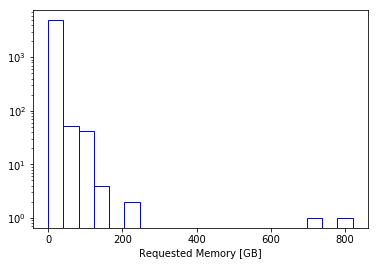

In [18]:
print(accre_data.ReqMemInBytes.max(),accre_data.ReqMemInBytes.min())
plt.hist(accre_data.ReqMemInBytes.dropna()/(10.**9),bins=20,histtype='bar',fill=False,edgecolor='blue')
plt.xlabel('Requested Memory [GB]')
plt.semilogy()

Text(0,0.5,'Wait Time [Hour]')

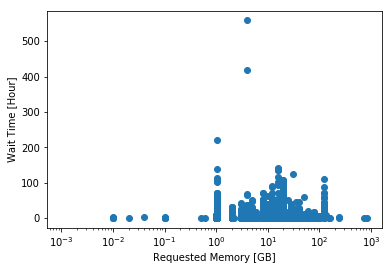

In [19]:
#print(accre_data.WaitTime)
#accre_data.WaitTime = pd.to_numeric(accre_data.WaitTime)
#print(accre_data.WaitTime)
plt.scatter(accre_data.ReqMemInBytes/(10.**9.),accre_data.WaitTime.astype('timedelta64[s]')/3600.)
plt.semilogx()
#plt.semilogy()
#plt.legend()
#plt.ylim(0.1,1000.)
plt.xlabel('Requested Memory [GB]')
plt.ylabel('Wait Time [Hour]')

Text(0,0.5,'Wait Time [Hour]')

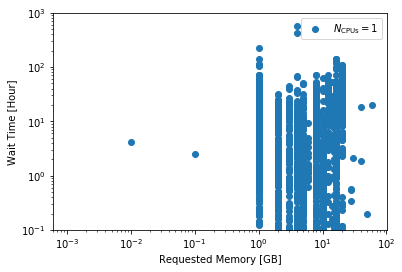

In [20]:
subset = accre_data.loc[accre_data.NCPUS == 1]
#print(subset.NCPUS)
plt.scatter(subset.ReqMemInBytes/(10.**9.),subset.WaitTime.astype('timedelta64[s]')/3600.,label=r'$N_{\rm CPUs} = 1$')
plt.semilogx()
plt.semilogy()
plt.legend()
plt.ylim(0.1,1000.)
plt.xlabel('Requested Memory [GB]')
plt.ylabel('Wait Time [Hour]')

Text(0,0.5,'Wait Time [Hour]')

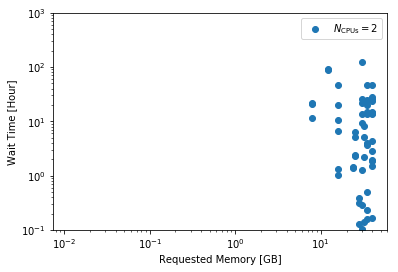

In [21]:
subset = accre_data.loc[accre_data.NCPUS == 2]
#print(subset.NCPUS)
plt.scatter(subset.ReqMemInBytes/(10.**9.),subset.WaitTime.astype('timedelta64[s]')/3600.,label=r'$N_{\rm CPUs} = 2$')
plt.semilogx()
plt.semilogy()
plt.legend()
plt.ylim(0.1,1000.)
plt.xlabel('Requested Memory [GB]')
plt.ylabel('Wait Time [Hour]')

Text(0,0.5,'Wait Time [Hour]')

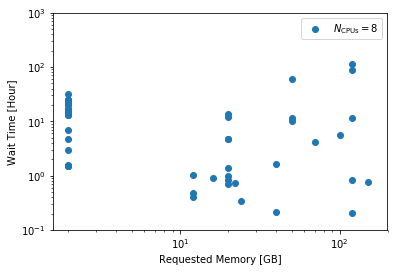

In [22]:
subset = accre_data.loc[accre_data.NCPUS == 8]
#print(subset.NCPUS)
plt.scatter(subset.ReqMemInBytes/(10.**9.),subset.WaitTime.astype('timedelta64[s]')/3600.,label=r'$N_{\rm CPUs} = 8$')
plt.semilogx()
plt.semilogy()
plt.legend()
plt.ylim(0.1,1000.)
plt.xlabel('Requested Memory [GB]')
plt.ylabel('Wait Time [Hour]')

Text(0,0.5,'Wait Time [Hour]')

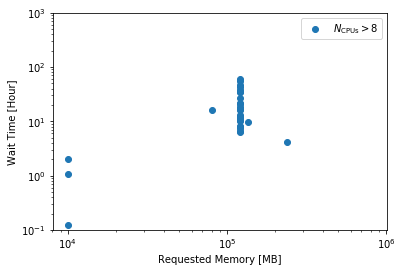

In [23]:
subset = accre_data.loc[accre_data.NCPUS > 8]
#print(subset.NCPUS)
plt.scatter(subset.ReqMemInBytes/(10.**6.),subset.WaitTime.astype('timedelta64[s]')/3600.,label=r'$N_{\rm CPUs} > 8$')
plt.semilogx()
plt.semilogy()
plt.legend()
plt.ylim(0.1,1000.)
plt.xlabel('Requested Memory [MB]')
plt.ylabel('Wait Time [Hour]')

Text(0,0.5,'Wait Time [Hour]')

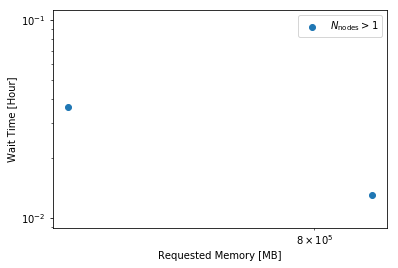

In [25]:
subset = accre_data.loc[accre_data.NNodes > 1]
#print(subset.NCPUS)
plt.scatter(subset.ReqMemInBytes/(10.**6.),subset.WaitTime.astype('timedelta64[s]')/3600.,label=r'$N_{\rm nodes} > 1$')
plt.semilogx()
plt.semilogy()
plt.legend()
#plt.ylim(0.1,1000.)
plt.xlabel('Requested Memory [MB]')
plt.ylabel('Wait Time [Hour]')

## Does a relationship exist between the number of CPUs requested by a user and their wait time in the queue?

[]

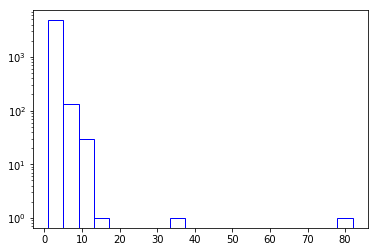

In [26]:
plt.hist(accre_data.NCPUS,bins=20,histtype='bar',fill=False,edgecolor='blue')
plt.semilogy()

Text(0,0.5,'Wait Time [Hour]')

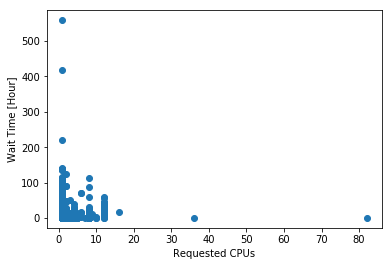

In [27]:
#print(accre_data.WaitTime)
#accre_data.WaitTime = pd.to_numeric(accre_data.WaitTime)
#print(accre_data.WaitTime)
plt.scatter(accre_data.NCPUS,accre_data.WaitTime.astype('timedelta64[s]')/3600.)
#plt.semilogx()
#plt.semilogy()
#plt.legend()
#plt.ylim(0.1,1000.)
plt.xlabel('Requested CPUs')
plt.ylabel('Wait Time [Hour]')

(array([[112.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   1.],
        [877.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.],
        [101.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   4.],
        [320.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,  10.],
        [980.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   3.],
        [ 27.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   8.],
        [  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [352.,   0.,   0.,   4.,   0.,   0.,   0.,   0.,   0.,   2.],
        [  3.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [325.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]]),
 array([ 0.01 ,  1.009,  2.008,  3.007,  4.006,  5.005,  6.004,  7.003,
         8.002,  9.001, 10.   ]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <matplotlib.image.AxesImage at 0x10cc8f5f8>)

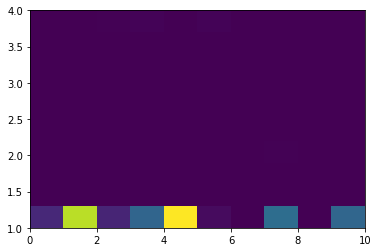

In [38]:
subset = accre_data.loc[(accre_data.NCPUS <= 4) & (accre_data.ReqMemInBytes <= 10.**10.)]
plt.hist2d(subset.ReqMemInBytes/(10.**9.),subset.NCPUS)

<IPython.core.display.Javascript object>


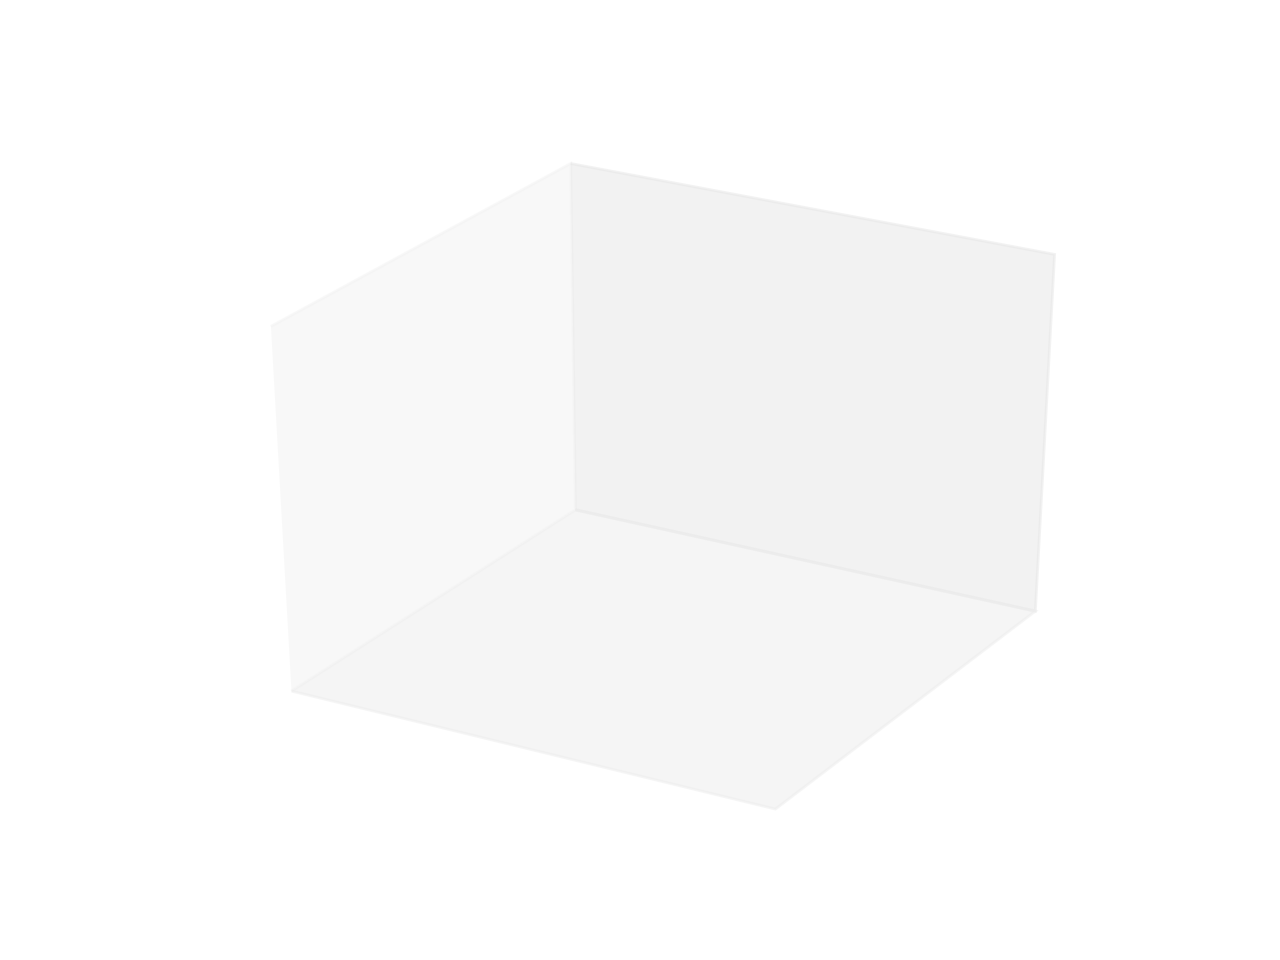

In [49]:
threedee = plt.figure().gca(projection='3d')
threedee.scatter(subset.WaitTime.astype('timedelta64[s]')/3600., subset.ReqMemInBytes/(10.**9.), subset.NCPUS)
threedee.set_xlabel('Wait Time [hours]')
threedee.set_ylabel('Requested Memory [GB]')
threedee.set_zlabel('NCPUs')
plt.show()

## Is there a relationship between the time of day of job submission and wait time in the queue?

<IPython.core.display.Javascript object>


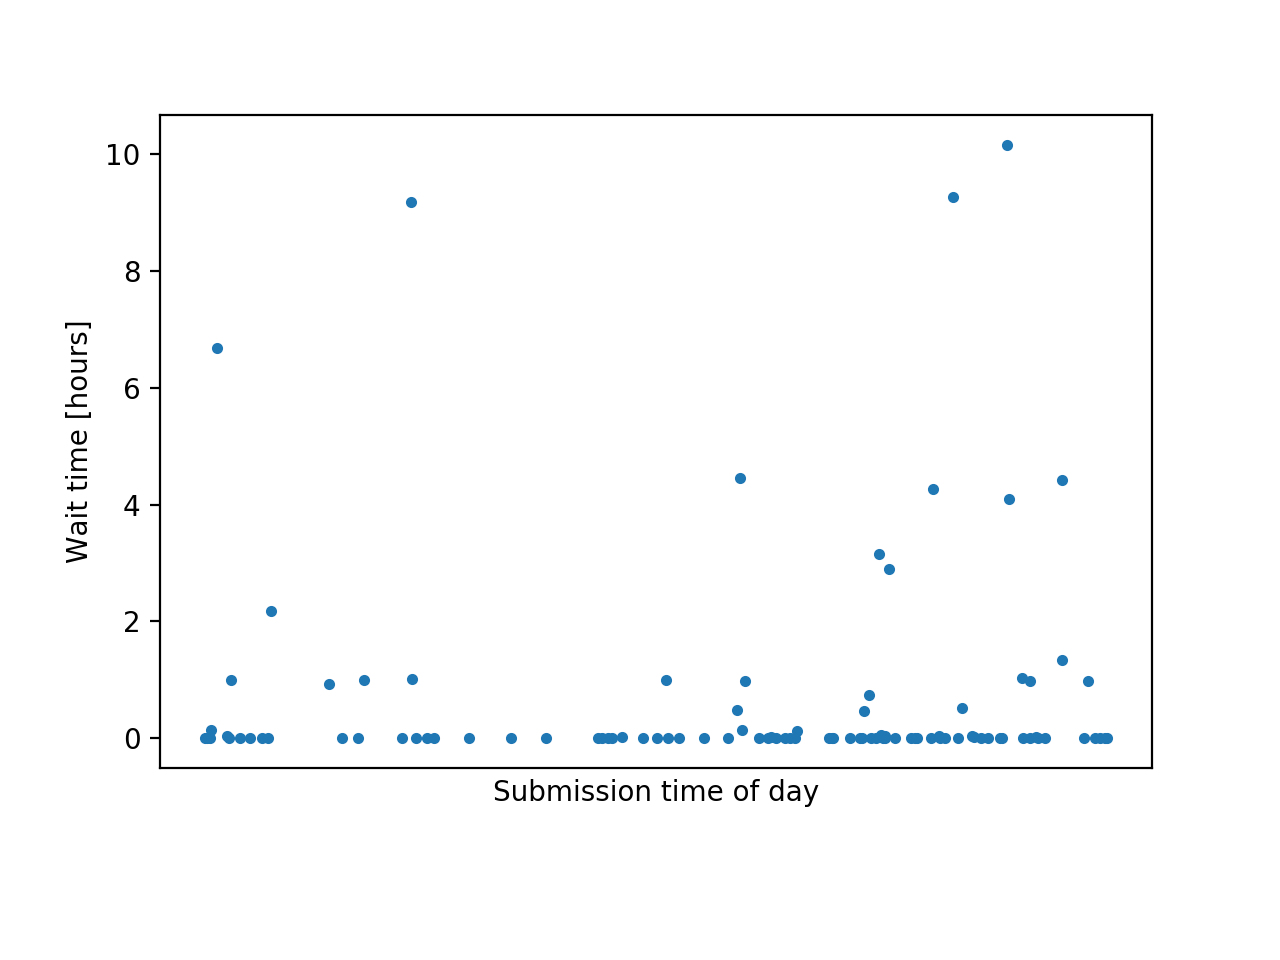

In [99]:
subset = accre_data.loc[(accre_data.NCPUS == 1) & (accre_data.ReqMemInBytes == 10.**9.)]
#subset.WaitTime.head()
hours = mdates.HourLocator(interval = 6)
h_fmt = mdates.DateFormatter('%H:%M:%S')
fig,ax = plt.subplots()
ax.plot(subset.Submit.dt.time,subset.WaitTime.astype('timedelta64[s]')/3600.,'.')
ax.set_ylabel('Wait time [hours]')
ax.set_xlabel('Submission time of day')
ax.xaxis.set_major_locator(hours)
ax.xaxis.set_major_formatter(h_fmt)
fig.autofmt_xdate(rotation=30)